# **Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
%matplotlib notebook
import sklearn
import skimage
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from skimage.feature import hog

import os
import pylab
from scipy import ndimage, misc
import cv2
import pickle

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [ ]:
dataset_path1 = "/content/drive/MyDrive/AI/Dataset/"
test_path = "/content/drive/MyDrive/AI/Testset/"
model_path = "/content/drive/MyDrive/AI/Model/"
labels_dict = {'glaucoma':0, 'Normal':1, 'Others':2}
number = 120

# **Function**

In [ ]:
def clahe(img_in):
  lab = cv2.cvtColor(img_in,cv2.COLOR_RGB2LAB)
  L, A, B = cv2.split(lab)
  clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
  L2 = clahe.apply(L)
  lab = cv2.merge((L2,A,B))
  im_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
  return im_clahe

In [ ]:
def get_test():

  test = []
  test_label = []
  tagname_file = os.listdir(test_path)
  for j,tagname in enumerate(tagname_file):
    image_file = os.listdir(test_path +tagname + '/')
    for j,img in enumerate(image_file):
      im = cv2.imread(test_path + tagname + '/' + img)
      im_rgb = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
      im_rgb = np.array(im_rgb)

      # Feature
      im_clahe = clahe(im_rgb)
      test.append(extract_features(im_clahe))
      test_label.append(labels_dict[tagname])
  test,test_label = shuffle(test,test_label)
  return test, test_label

In [ ]:
def split_train_val(tagname, i):
  dataset_glaucoma = os.listdir(dataset_path1 + tagname)
  val_index = 4-i
  train = []
  train_label = []
  val = []
  val_label = []
  print(tagname)
  for k in range(0,5):
    if k == val_index :
      image_file = os.listdir(dataset_path1 + tagname + '/' + str(k))
      print(image_file)
      for j,img in enumerate(image_file):
        if j < number :
          im = cv2.imread(dataset_path1 + tagname + '/' + str(k) + '/' + img)
          im_rgb = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
          im_rgb = np.array(im_rgb)
          
          # Feature
          im_clahe = clahe(im_rgb)
          val.append(extract_features(im_clahe))
          val_label.append(labels_dict[tagname])
    else:
      image_file = os.listdir(dataset_path1 + tagname + '/' + str(k))
      print(image_file)
      for j,img in enumerate(image_file):
        if j < number :
          im = cv2.imread(dataset_path1 + tagname + '/' + str(k) + '/' + img)
          im_rgb = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
          im_rgb = np.array(im_rgb)

          # Feature
          im_clahe = clahe(im_rgb)
          train.append(extract_features(im_clahe))
          train_label.append(labels_dict[tagname])
          
  return train, train_label, val, val_label

In [ ]:
def shuffle(data, label):
  new_data = []
  new_label = []
  index = [i for i in range(len(data))]
  np.random.shuffle(index)
  for i in range(len(data)):
    new_data.append(data[index[i]])
    new_label.append(label[index[i]])
  return new_data, new_label
  


In [ ]:
def sum_data(k):
  file_name = os.listdir(dataset_path1)
  train = []
  train_label = []
  val = []
  val_label = []
  for name in file_name:
    print(name)
    train_name, train_name_label, val_name, val_name_label = split_train_val(name, k)
    train.extend(train_name)
    train_label.extend(train_name_label)
    val.extend(val_name)
    val_label.extend(val_name_label)
  return train, train_label, val, val_label

In [ ]:
from sklearn.preprocessing import StandardScaler
def scaling(X_data) :
    #Feature Scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_data)
    return X_train

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def confusion(y_test,pred) :
    #Confusion Matrix
    %matplotlib inline 
    confusion_mat1 = confusion_matrix(y_test, pred)
    sns.heatmap(confusion_mat1,annot=True,linewidths=1, fmt = 'd')
    plt.show()

In [ ]:
def extract_features(image):
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
    hog_image = hog_image.mean(axis=0)
    return hog_image

In [ ]:
def roc(fpr_recv,tpr_recv,acc_recv,num=5) :
    color = ["orange","green","blue","red","purple"]
    for i in range(num):
        fpr_use = fpr_recv[i]
        tpr_use = tpr_recv[i]
        acc_use = acc_recv[i]
        plt.plot(fpr_use, tpr_use, color='{}'.format(color[i]), label='AUC Fold %d: %0.4f' %(i,acc_use))
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend()
        
    plt.show()

# **Model**

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import keras

def knn_model(X_train_recv, y_train_recv, X_val_recv, y_val_recv, r) :

    
    knn = KNeighborsClassifier(n_neighbors=5)

    print("Wait for Trainning")
    knn.fit(X_train_recv,y_train_recv)
    filename = 'model_'+ str(r) +'.h5'
    pickle.dump(knn, open("/content/drive/MyDrive/AI/Model/" +filename, 'wb'))

    y_pred = knn.predict(X_val_recv)

    accuracy = accuracy_score(y_val_recv,y_pred)
    print("KNN accuracy from Round {} : {}".format(r+1,accuracy))

    %matplotlib inline 
    confusion(y_val_recv,y_pred)
  
    fpr_sav = []
    tpr_sav = []
    acc_sav = []
    for i in range(0,3) :
      y_score = knn.predict_proba(X_val_recv)[:, i]
      y_true = keras.utils.to_categorical(y_val_recv, 3)[:, i]

      fpr, tpr, thresholds = roc_curve(y_true, y_score)
      roc_auc = metrics.auc(fpr, tpr)
      fpr_sav.append(fpr)
      tpr_sav.append(tpr)
      acc_sav.append(roc_auc)

    return fpr_sav, tpr_sav, acc_sav

# **Train**

Others
Others
['Others_55.png', 'Others_24.png', 'Others_12.png', 'Others_60.png', 'Others_1.png', 'Others_16.png', 'Others_64.png', 'Others_48.png', 'Others_7.png', 'Others_40.png', 'Others_30.png', 'Others_35.png', 'Others_82.png', 'Others_109.png', 'Others_138.png', 'Others_121.png', 'Others_86.png', 'Others_96.png', 'Others_170.png', 'Others_77.png', 'Others_127.png', 'Others_186.png', 'Others_153.png', 'Others_182.png', 'Others_147.png', 'Others_162.png', 'Others_103.png', 'Others_158.png', 'Others_132.png', 'Others_113.png', 'Others_175.png', 'Others_72.png', 'Others_201.png', 'Others_225.png', 'Others_244.png', 'Others_230.png', 'Others_305.png', 'Others_235.png', 'Others_280.png', 'Others_211.png', 'Others_259.png', 'Others_309.png', 'Others_269.png', 'Others_285.png', 'Others_254.png', 'Others_207.png', 'Others_300.png', 'Others_220.png', 'Others_249.png', 'Others_293.png', 'Others_275.png', 'Others_196.png', 'Others_380.png', 'Others_334.png', 'Others_354.png', 'Others_392.pn

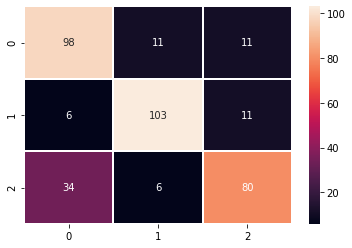

Others
Others
['Others_55.png', 'Others_24.png', 'Others_12.png', 'Others_60.png', 'Others_1.png', 'Others_16.png', 'Others_64.png', 'Others_48.png', 'Others_7.png', 'Others_40.png', 'Others_30.png', 'Others_35.png', 'Others_82.png', 'Others_109.png', 'Others_138.png', 'Others_121.png', 'Others_86.png', 'Others_96.png', 'Others_170.png', 'Others_77.png', 'Others_127.png', 'Others_186.png', 'Others_153.png', 'Others_182.png', 'Others_147.png', 'Others_162.png', 'Others_103.png', 'Others_158.png', 'Others_132.png', 'Others_113.png', 'Others_175.png', 'Others_72.png', 'Others_201.png', 'Others_225.png', 'Others_244.png', 'Others_230.png', 'Others_305.png', 'Others_235.png', 'Others_280.png', 'Others_211.png', 'Others_259.png', 'Others_309.png', 'Others_269.png', 'Others_285.png', 'Others_254.png', 'Others_207.png', 'Others_300.png', 'Others_220.png', 'Others_249.png', 'Others_293.png', 'Others_275.png', 'Others_196.png', 'Others_380.png', 'Others_334.png', 'Others_354.png', 'Others_392.pn

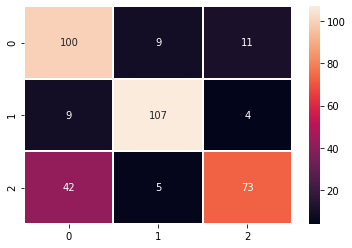

Others
Others
['Others_55.png', 'Others_24.png', 'Others_12.png', 'Others_60.png', 'Others_1.png', 'Others_16.png', 'Others_64.png', 'Others_48.png', 'Others_7.png', 'Others_40.png', 'Others_30.png', 'Others_35.png', 'Others_82.png', 'Others_109.png', 'Others_138.png', 'Others_121.png', 'Others_86.png', 'Others_96.png', 'Others_170.png', 'Others_77.png', 'Others_127.png', 'Others_186.png', 'Others_153.png', 'Others_182.png', 'Others_147.png', 'Others_162.png', 'Others_103.png', 'Others_158.png', 'Others_132.png', 'Others_113.png', 'Others_175.png', 'Others_72.png', 'Others_201.png', 'Others_225.png', 'Others_244.png', 'Others_230.png', 'Others_305.png', 'Others_235.png', 'Others_280.png', 'Others_211.png', 'Others_259.png', 'Others_309.png', 'Others_269.png', 'Others_285.png', 'Others_254.png', 'Others_207.png', 'Others_300.png', 'Others_220.png', 'Others_249.png', 'Others_293.png', 'Others_275.png', 'Others_196.png', 'Others_380.png', 'Others_334.png', 'Others_354.png', 'Others_392.pn

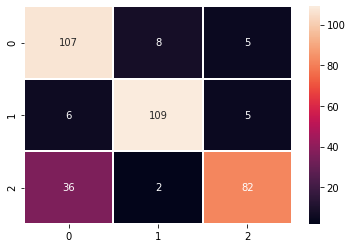

Others
Others
['Others_55.png', 'Others_24.png', 'Others_12.png', 'Others_60.png', 'Others_1.png', 'Others_16.png', 'Others_64.png', 'Others_48.png', 'Others_7.png', 'Others_40.png', 'Others_30.png', 'Others_35.png', 'Others_82.png', 'Others_109.png', 'Others_138.png', 'Others_121.png', 'Others_86.png', 'Others_96.png', 'Others_170.png', 'Others_77.png', 'Others_127.png', 'Others_186.png', 'Others_153.png', 'Others_182.png', 'Others_147.png', 'Others_162.png', 'Others_103.png', 'Others_158.png', 'Others_132.png', 'Others_113.png', 'Others_175.png', 'Others_72.png', 'Others_201.png', 'Others_225.png', 'Others_244.png', 'Others_230.png', 'Others_305.png', 'Others_235.png', 'Others_280.png', 'Others_211.png', 'Others_259.png', 'Others_309.png', 'Others_269.png', 'Others_285.png', 'Others_254.png', 'Others_207.png', 'Others_300.png', 'Others_220.png', 'Others_249.png', 'Others_293.png', 'Others_275.png', 'Others_196.png', 'Others_380.png', 'Others_334.png', 'Others_354.png', 'Others_392.pn

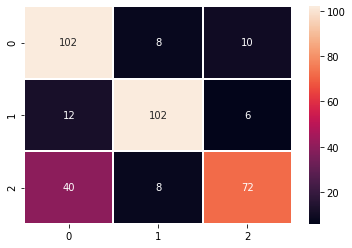

Others
Others
['Others_55.png', 'Others_24.png', 'Others_12.png', 'Others_60.png', 'Others_1.png', 'Others_16.png', 'Others_64.png', 'Others_48.png', 'Others_7.png', 'Others_40.png', 'Others_30.png', 'Others_35.png', 'Others_82.png', 'Others_109.png', 'Others_138.png', 'Others_121.png', 'Others_86.png', 'Others_96.png', 'Others_170.png', 'Others_77.png', 'Others_127.png', 'Others_186.png', 'Others_153.png', 'Others_182.png', 'Others_147.png', 'Others_162.png', 'Others_103.png', 'Others_158.png', 'Others_132.png', 'Others_113.png', 'Others_175.png', 'Others_72.png', 'Others_201.png', 'Others_225.png', 'Others_244.png', 'Others_230.png', 'Others_305.png', 'Others_235.png', 'Others_280.png', 'Others_211.png', 'Others_259.png', 'Others_309.png', 'Others_269.png', 'Others_285.png', 'Others_254.png', 'Others_207.png', 'Others_300.png', 'Others_220.png', 'Others_249.png', 'Others_293.png', 'Others_275.png', 'Others_196.png', 'Others_380.png', 'Others_334.png', 'Others_354.png', 'Others_392.pn

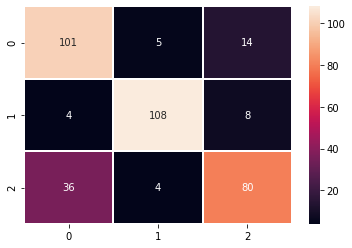

Graph Class  0


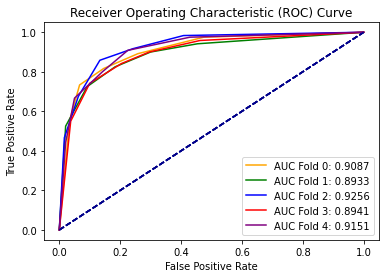

Graph Class  1


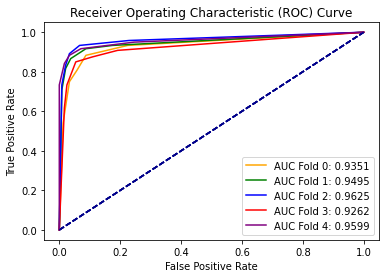

Graph Class  2


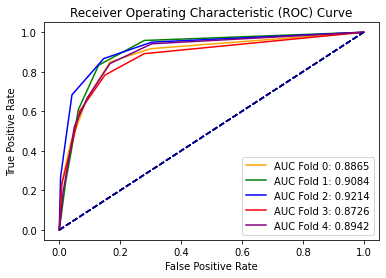

In [ ]:
# import image from dataset
fpr_all = []
tpr_all = []
acc_all = []
for i in range(0,5):
  # Round 1 use 4 to val
  # Round 2 use 3 to val
  # Round 3 use 2 to val
  # Round 4 use 1 to val
  # Round 5 use 0 to val
  train_data, train_label, val_data, val_label = sum_data(i) 
  print(len(train_data), len(train_label), len(val_data), len(val_label))
  train_data, train_label = shuffle(train_data,train_label)
  val_data, val_label = shuffle(val_data,val_label)
  print(len(train_data), len(train_label), len(val_data), len(val_label))

  ## Model
  #  Roc curve ของ 3 classes
  fpr, tpr, acc = knn_model(train_data, train_label, val_data, val_label, i)
  fpr_all.append(fpr)
  tpr_all.append(tpr)
  acc_all.append(acc)

fpr_all = np.array(fpr_all)
tpr_all = np.array(tpr_all)
acc_all = np.array(acc_all)
for u in range(3):
  print("Graph Class ", str(u))
  roc(fpr_all[:,u], tpr_all[:,u], acc_all[:,u])


# **Test with test set**

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics
# Python script for confusion matrix creation. 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

In [ ]:
# load the model from disk
filename = "/content/drive/MyDrive/AI/Model/model_1.h5"
loaded_model = pickle.load(open(filename, 'rb'))
X_test, Y_test = get_test()
print(type(X_test))
print(type(Y_test))
print(Y_test)
result = loaded_model.score(X_test, Y_test)
print(result)
y_pred = loaded_model.predict(X_test)

<class 'list'>
<class 'list'>
[0, 2, 1, 2, 2, 0, 1, 1, 2, 0, 1, 0, 2, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 1, 1, 0, 2, 0, 1, 0, 1, 0, 1, 2, 2, 0, 2, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 2, 1, 1, 0, 2, 0, 0, 1, 1, 1, 2, 0, 0, 0, 1, 0, 1, 0, 1, 2, 0, 1, 0, 2, 0, 0, 2, 2, 2, 2, 1, 2, 0, 1, 0, 0, 0, 0, 1, 1, 2, 0, 1, 0, 1, 1, 1, 0, 1, 1, 2, 2, 0, 1, 2, 2, 1, 2, 1, 1, 0, 1, 0, 1, 0, 0, 1, 2, 0, 0, 1, 1, 1, 1, 2, 0, 2, 1, 0, 0, 2, 0, 0, 2, 0, 2, 1, 1, 0, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 2, 0, 1, 0, 0, 0, 2, 1, 2, 1, 2, 2, 0, 1, 0, 0, 1, 2, 2, 2, 0, 1, 1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 1, 2, 1, 0, 0, 1, 0, 0, 1, 0, 0, 2, 2, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 2, 0, 1, 1, 0, 1, 1, 2, 1, 0, 0, 0, 1, 0, 2, 0, 1, 1, 2, 2, 1, 2, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 2, 2, 2, 0, 1, 0, 1, 0, 2, 1, 1, 1, 2, 2, 0, 2, 1, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 1, 0, 1]
0.6666666666666666


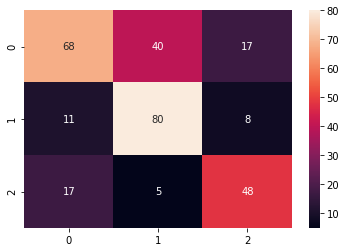

Confusion Matrix : 
 [[68 40 17]
 [11 80  8]
 [17  5 48]]
Accuracy :  0.6666666666666666
Sensitivity Class 0:  0.7083333333333334
Specificity Class 0:  0.834319526627219
Sensitivity Class 1:  0.64
Specificity Class 1:  0.7692307692307693
Sensitivity Class 2:  0.6575342465753424
Specificity Class 2:  0.9004524886877828
Report : 
              precision    recall  f1-score   support

           0     0.7083    0.5440    0.6154       125
           1     0.6400    0.8081    0.7143        99
           2     0.6575    0.6857    0.6713        70

    accuracy                         0.6667       294
   macro avg     0.6686    0.6793    0.6670       294
weighted avg     0.6732    0.6667    0.6620       294



In [ ]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix
%matplotlib inline

cm1 = confusion_matrix(Y_test,y_pred)
sns.heatmap(cm1, annot=True)
plt.show()

print('Confusion Matrix : \n', cm1)

total=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy0=(cm1[0,0]+cm1[1,1]+cm1[2,2])/total
print ('Accuracy : ', accuracy0)

sensitivity0 = cm1[0,0]/(cm1[0,0]+cm1[1,0]+cm1[2,0])
print('Sensitivity Class 0: ', sensitivity0 )

specificity0 = (cm1[1,1]+cm1[2,2]+cm1[1,2]+cm1[2,1])/(cm1[1,0]+cm1[1,1]+cm1[1,2]+cm1[2,0]+cm1[2,1]+cm1[2,2])
print('Specificity Class 0: ', specificity0)

sensitivity1 = cm1[1,1]/(cm1[1,1]+cm1[0,1]+cm1[2,1])
print('Sensitivity Class 1: ', sensitivity1)

specificity1 = (cm1[0,0]+cm1[0,2]+cm1[2,0]+cm1[2,2])/(cm1[0,0]+cm1[0,2]+cm1[2,0]+cm1[2,2]+cm1[0,1]+cm1[2,1])
print('Specificity Class 1: ', specificity1)

sensitivity2 = cm1[2,2]/(cm1[2,2]+cm1[0,2]+cm1[1,2])
print('Sensitivity Class 2: ', sensitivity2)

specificity2 = (cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1]+cm1[2,0]+cm1[2,1])
print('Specificity Class 2: ', specificity2)

print( 'Report : ')
print (classification_report(Y_test,y_pred,digits=4))
